# <center> Using otagrum </center>

In [1]:
import openturns as ot
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

## Importing the otagrum module

In [2]:
import otagrum as otagr

## Creating the CBN structure

We begin by creating the CBN that will be used throughout this example.

To do so, we need a NamedDAG structure...

In [3]:
dag = gum.DAG()

In [4]:
mapping = {}
mapping['A'] = dag.addNode() # Add node A
mapping['B'] = dag.addNode() # Add node B
mapping['C'] = dag.addNode() # Add node C
mapping['D'] = dag.addNode() # Add node D

In [5]:
dag.addArc(mapping['A'], mapping['C']) # Arc A -> C
dag.addArc(mapping['B'], mapping['C']) # Arc B -> C
dag.addArc(mapping['C'], mapping['D']) # Arc C -> D

In [6]:
dag

<pyAgrum.pyAgrum.DAG; proxy of <Swig Object of type 'gum::DAG *' at 0x7f9ebaed73f0> >

In [7]:
structure = otagr.NamedDAG(dag, list(mapping.keys()))

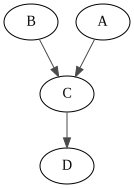

In [11]:
gnb.showDot(structure.toDot())

## Parameters of the CBN

... and a collection of local conditional copulas.

In [12]:
lcc_list = [] # Local Conditional Copulas
for i in range( structure.getSize() ):
    dim_lcc = structure.getParents(i).getSize() + 1
    R = ot.CorrelationMatrix(dim_lcc)
    for j in range(dim_lcc):
        for k in range(j):
            R[j, k] = 0.6
    lcc_list.append( ot.Normal([0.0]*dim_lcc, [1.0]*dim_lcc, R).getCopula() )

## Creation of the CBN

Now that we have a NamedDAG structure and a collection of local conditional copulas, we can construct a CBN.

In [14]:
cbn = otagr.ContinuousBayesianNetwork(structure, lcc_list)

## Sampling from CBN

Having a CBN, we can now sample from it.

In [15]:
ot.RandomGenerator.SetSeed(10) # Set random seed
sample = cbn.getSample(1000)
train = sample[:-100]
test = sample[-100:]

## Learning the structure with continuous PC

Now that we have data, we can use it to learn the structure with the continuous PC algorithm.

In [16]:
learner = otagr.ContinuousPC(sample, maxConditioningSetSize=5, alpha=0.1)

### Skeleton learning

We first learn the skeleton, that is the undirected structure.

In [17]:
skeleton = learner.learnSkeleton()

In [18]:
skeleton

(gum::UndiGraph@0x55b12c050550) {0,1,2,3} , {2--3,0--2,1--2}

Then we look for the v-structures, leading to a Partially Directed Acyclic Graph (PDAG) 

In [19]:
pdag = learner.learnPDAG()

In [20]:
pdag

(gum::MixedGraph@0x55b12c07d4e0) {0,1,2,3} , {1->2,0->2} , {2--3}

Finally, the remaining edges are oriented by propagating constraints

In [21]:
ndag = learner.learnDAG()

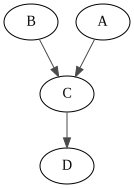

In [69]:
gnb.showDot(structure.toDot())

The true structure has been recovered.

## Learning parameters

Bernstein copulas are used to learn the local conditional copulas associated to each node

In [66]:
lcc_list = []
for i in range(train.getDimension()):
    indices = [i] + [int(n) for n in ndag.getParents(i)]
    dim_lcc = len(indices)
    if dim_lcc == 1:
        bernsteinCopula = ot.Uniform(0.0, 1.0).getCopula()
    elif dim_lcc > 1:
        K = otagr.ContinuousTTest.GetK(len(train), dim_lcc)
        bernsteinCopula = ot.EmpiricalBernsteinCopula(train.getMarginal(indices), K, True)
    lcc_list.append(bernsteinCopula)

We can now create the learned CBN

In [67]:
lcbn = otagr.ContinuousBayesianNetwork(ndag, lcc_list) # Learned CBN

In [27]:
true_LL = compute_mean_LL(cbn, test)
print(true_LL)

0.316209061434805


In [26]:
exp_LL = compute_mean_LL(lcbn, test)
print(exp_LL)

0.1289760450076917
